## 測試Clean Chinese HandWrite data 使用不同Classifier的預測結果

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from  sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
random_state = 0

# 測試50個字

In [2]:
img_list = []
data_path = './syn_test/'
num_class = 50
#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            

In [3]:
img_list

[('./syn_test/0/宋_46.jpg', 0),
 ('./syn_test/0/宋_42.jpg', 0),
 ('./syn_test/0/宋_10.jpg', 0),
 ('./syn_test/0/宋_36.jpg', 0),
 ('./syn_test/0/宋_5.jpg', 0),
 ('./syn_test/0/宋_45.jpg', 0),
 ('./syn_test/0/宋_2.jpg', 0),
 ('./syn_test/0/宋_44.jpg', 0),
 ('./syn_test/0/宋_30.jpg', 0),
 ('./syn_test/0/宋_3.jpg', 0),
 ('./syn_test/0/宋_34.jpg', 0),
 ('./syn_test/0/宋_47.jpg', 0),
 ('./syn_test/0/宋_31.jpg', 0),
 ('./syn_test/0/宋_8.jpg', 0),
 ('./syn_test/0/宋_4.jpg', 0),
 ('./syn_test/0/宋_35.jpg', 0),
 ('./syn_test/0/宋_0.jpg', 0),
 ('./syn_test/0/宋_28.jpg', 0),
 ('./syn_test/0/宋_7.jpg', 0),
 ('./syn_test/0/宋_49.jpg', 0),
 ('./syn_test/0/宋_41.jpg', 0),
 ('./syn_test/0/宋_33.jpg', 0),
 ('./syn_test/0/宋_17.jpg', 0),
 ('./syn_test/0/宋_26.jpg', 0),
 ('./syn_test/0/宋_11.jpg', 0),
 ('./syn_test/0/宋_13.jpg', 0),
 ('./syn_test/0/宋_22.jpg', 0),
 ('./syn_test/0/宋_21.jpg', 0),
 ('./syn_test/0/宋_25.jpg', 0),
 ('./syn_test/0/宋_9.jpg', 0),
 ('./syn_test/0/宋_24.jpg', 0),
 ('./syn_test/0/宋_27.jpg', 0),
 ('./syn_test/0/

## Load Image

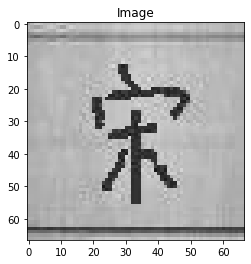

In [4]:
plt.title('Image')
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

In [5]:
total_img = []
total_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((50,50),Image.BILINEAR)
    total_label.append(label)
    total_img.append(np.array(img).reshape(-1))
total_img = np.array(total_img)
total_label = np.array(total_label)
print("Total label shape:",total_label.shape)
print("Total image shape:",total_img.shape)

Total label shape: (2581,)
Total image shape: (2581, 2500)


# Split train and test set

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.2,random_state=0)
X_train_scale = preprocessing.scale(X_train)
X_test_scale = preprocessing.scale(X_test)

# PCA explain ratio

Text(0, 0.5, 'cumulative explained variance')

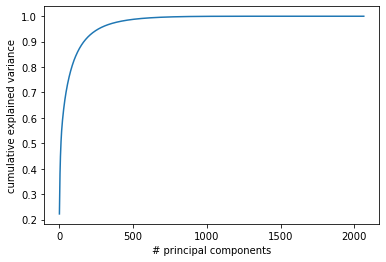

In [48]:
# 多少components 就可以代表0.95的資料
n_compons_rate = 0.95
pca = PCA()
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

dim reduction one image

principle components shape: (2064, 2500)


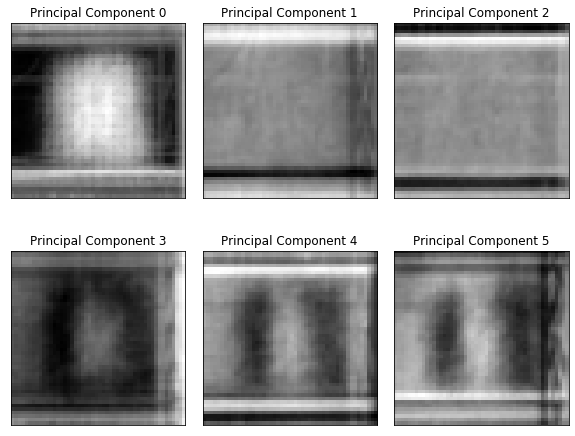

In [49]:
from sklearn.preprocessing import minmax_scale
pca = PCA(random_state=0)
trans_img = pca.fit_transform(X_train_scale)

scaled_comps = minmax_scale(pca.components_,axis=1)
print("principle components shape:",pca.components_.shape)
fig,axes = plt.subplots(2,3,figsize=(10,8),
                        subplot_kw = {"xticks":[],'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.set_title('Principal Component '+str(i))
    ax.imshow(c.reshape(50,50),cmap='gray')


# predict function

In [7]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

## Confusion matrix 

In [51]:
def plot_confusion_matrix(confuse_matrix,title="Confusion Matrix",cmap=plt.cm.Blues):
    plt.imshow(confuse_matrix,interpolation='nearst',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks,names,rotation=90)
    plt.yticks(tick_marks,names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## PCA components數 影響 SVM accuracy

In [52]:
def differ_components_SVM(X_train,Y_train,X_test,Y_test,):
    best_acc = 0
    best_rate = 100
    for i in range(90,0,-10):
        pca = PCA(i/100,random_state=random_state)
        pca.fit(X_train)
        transformed_images = pca.transform(X_train)
    #     print("transformed_images.shape:",transformed_images.shape)
        transform_test = pca.transform(X_test)
        clf = svm.SVC()
        clf.fit(transformed_images,Y_train)
        res = clf.predict(transform_test)
        acc = predict_accuracy(res,Y_test)
        if best_acc<acc:
            best_acc = acc
            best_rate = i/100
        
        print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))
    print("Best accuracy:{:.2%} , Best component rate:{}".format(best_acc,best_rate))


In [ ]:
differ_components_SVM(X_train_scale,Y_train,X_test_scale,Y_test)

## PCA

In [8]:
pca = PCA(0.8,random_state=random_state)
# pca.fit(X_train_scale)
pipe = make_pipeline(StandardScaler(),pca)
pipe.fit(X_train)
transformed_train = pipe.transform(X_train)
transformed_test = pipe.transform(X_test)

print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)


-----PCA dimension reduction----
transformed train images.shape: (2112, 233)
transformed test  images.shape: (529, 233)


## PCA reconstruct Image with different   component

In [13]:
def diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k):
    diff_reconstruct=[]
    diff_reconstruct.append((Image.fromarray(X_train[k].reshape(50,50) ,'L'),"Ori_img"))

    for i in range(95,0,-10):
        pca = PCA(i/100,random_state=0)
        pca.fit(X_train_scale)
        transformed_train = pca.transform(X_train_scale)
        reconstruct_image = pca.inverse_transform(transformed_train)
        reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
        img_pca = Image.fromarray(reconstruct_image[k],'L')
        print("components_number:",pca.components_.shape[0])
        diff_reconstruct.append((img_pca,pca.components_.shape[0]))
    fig, axes = plt.subplots(1,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        img_pca = diff_reconstruct[i][0]
        ax.set_title(diff_reconstruct[i][1])
        ax.imshow(img_pca,cmap='gray')
       
   
diff_component_reconstruct(X_train_scale,X_test_scale,X_train,k=10)

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(3,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

reconstruct_image = pca.inverse_transform(transformed_train)
reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
for i, ax in enumerate(axes.flat):
        img_pca = Image.fromarray(reconstruct_image[i] ,'L')
        ax.imshow(img_pca,cmap='gray')

# LDA

In [15]:
def LDA(X_train,Y_train,X_test,Y_test):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train,Y_train)
    transform_images = lda.transform(X_train)
    transform_test = lda.transform(X_test)
    return transform_images,transform_test
lda_train,lda_test = LDA(X_train_scale,Y_train,X_test_scale,Y_test)

## KPCA

In [16]:
from sklearn.decomposition import KernelPCA
def KPCA(X_train,Y_train,X_test,Y_test):
    kpca = KernelPCA(n_components=232,kernel='linear')
    kpca.fit(X_train)
    transform_images = kpca.transform(X_train)
    transform_test = kpca.transform(X_test)
    return transform_images,transform_test
kpca_train,kpca_test = KPCA(X_train_scale,Y_train,X_test_scale,Y_test)

# SVM 

In [41]:
def SVM(X_train,Y_train,X_test,Y_test,k):
    nor_train =  preprocessing.normalize(X_train)
    nor_test = preprocessing.normalize(X_test)
    pca = PCA(0.8,random_state=random_state)
    pca.fit(nor_train)
    transform_train = pca.transform(nor_train)
    transform_test  = pca.transform(nor_test)
    clf = svm.SVC(kernel=k,random_state=random_state)
    clf.fit(transform_train,Y_train)
    res = clf.predict(transform_test)
    return predict_accuracy(res,Y_test)
svm_res = []
ker = ['rbf','poly','sigmoid','linear']
for i in ker:
    svm_res.append(SVM(X_train,Y_train,X_test,Y_test,i))
# print("PCA+SVM:{:.2%}".format(SVM(transformed_train,Y_train,transformed_test,Y_test))) 
# print("KPCA+SVM:{:.2%}".format(SVM(kpca_train,Y_train,kpca_test,Y_test))) 
# print("LDA+SVM:{:.2%}".format(SVM(lda_train,Y_train,lda_test,Y_test)))


In [42]:
svm_res

[0.7599243856332704,
 0.18525519848771266,
 0.7051039697542533,
 0.04914933837429111]

## KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(X_train,Y_train,X_test,Y_test,k):
    knn =  KNeighborsClassifier(n_neighbors=k)
    nor_train =  preprocessing.normalize(X_train)
    nor_test = preprocessing.normalize(X_test)
    pca = PCA(0.8,random_state=random_state)
    pca.fit(nor_train)
    transform_train = pca.transform(nor_train)
    transform_test  = pca.transform(nor_test)
    
    knn.fit(transform_train,Y_train)
    res = knn.predict(transform_test)
#     knn_cm = metrics.confusion_matrix(Y_test,res)
    
   
    return predict_accuracy(res,Y_test)

# print("PCA+KNN:{:.2%}".format(KNN(X_train,Y_train,X_test,Y_test))) 
# print("KPCA+KNN:{:.2%}".format(KNN(kpca_train,Y_train,kpca_test,Y_test))) 
# print("LDA+KNN:{:.2%}".format(KNN(lda_train,Y_train,lda_test,Y_test)))



res_knn = []
for i in [1,5,9,15,50,100]:
    res_knn.append(KNN(X_train,Y_train,X_test,Y_test,i))

In [36]:
res_knn

[0.6502835538752363,
 0.5103969754253308,
 0.45935727788279773,
 0.4102079395085066,
 0.3005671077504726,
 0.2003780718336484]

# Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
def perceptron(X_train,Y_train,X_test,Y_test):
    clf =Perceptron(tol=1e-5,random_state=random_state)
    clf.fit(X_train,Y_train)
    clf.score(X_train,Y_train)
    clf.score(X_test,Y_test)
    res = clf.score(X_test,Y_test)
    return res
print("PCA+Perceptron:{:.2%}".format(perceptron(transformed_train,Y_train,transformed_test,Y_test))) 
print("KPCA+Perceptron:{:.2%}".format(perceptron(kpca_train,Y_train,kpca_test,Y_test))) 
print("LDA+Perceptron:{:.2%}".format(perceptron(lda_train,Y_train,lda_test,Y_test)))

# MLP

In [48]:
mlp_res = [] 

def MLP(X_train,Y_train,X_test,Y_test,hidden_layer,max_iter ):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer,solver='adam',activation='relu',max_iter=max_iter,random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)
max_iter= 5000
hidden_size = (256,256,128)
print("PCA+MLP:{:.2%}".format(MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size,max_iter))) 
print("KPCA+MLP:{:.2%}".format(MLP(kpca_train,Y_train,kpca_test,Y_test,hidden_size,max_iter))) 
print("LDA+MLP:{:.2%}".format(MLP(lda_train,Y_train,lda_test,Y_test,hidden_size,max_iter)))
for i in range (128,2500,128):
    print(i)
    hidden_size = (i)
    mlp_res.append(MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size,max_iter))
   


PCA+MLP:71.64%
KPCA+MLP:68.05%
LDA+MLP:11.53%
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432


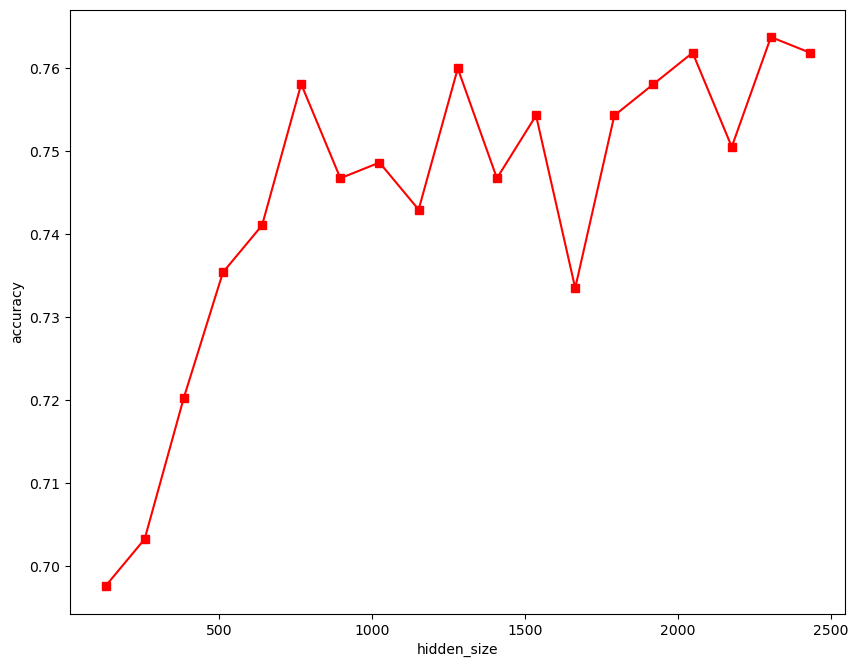

In [51]:
x_ = [i for i in range(128,2500,128)]
mlp_res
plt.figure(figsize=(10,8),dpi=100,linewidth = 2)
plt.xlabel('hidden_size')
plt.ylabel('accuracy')
plt.plot(x_,mlp_res,'s-',color = 'r')

## Naive Bayes

In [39]:
from sklearn.naive_bayes import *
Categorical_NB = CategoricalNB()
Categorical_NB.fit(X_train, Y_train)
res = Categorical_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.07561436672967864

In [45]:
Complement_NB = ComplementNB()
Complement_NB.fit(X_train, Y_train)
res = Complement_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.4763705103969754

In [53]:
Gaussian_NB = GaussianNB()
Gaussian_NB.fit(X_train, Y_train)
res = Gaussian_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.2438563327032136

In [52]:
Multinomial_NB = MultinomialNB()
Multinomial_NB.fit(X_train, Y_train)
res = Multinomial_NB.predict(X_test)
predict_accuracy(res,Y_test)

0.5822306238185255

In [11]:
def get_bin_table(threshold=128):
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    return table

def remove_noise_pixel(img, noise_point_list):
    for item in noise_point_list:
        img.putpixel((item[0], item[1]), 1)

def collect_noise_point(img):
    noise_point_list = []
    for x in range(img.width):
        for y in range(img.height):
            res_9 = sum_9_region_new(img, x, y)
            if (0 < res_9 < 3) and img.getpixel((x, y)) == 0:
                pos = (x, y)
                noise_point_list.append(pos)
    return noise_point_list

def sum_9_region_new(img, x, y):
    cur_pixel = img.getpixel((x, y))
    width = img.width
    height = img.height
    if cur_pixel == 1:
        return 0
    if y < 3:
        return 1
    elif y > height - 3:
        return 1
    else:
        if x < 3:
            return 1
        elif x == width - 1:
            return 1
        else:
            sum = img.getpixel((x - 1, y - 1)) \
                  + img.getpixel((x - 1, y)) \
                  + img.getpixel((x - 1, y + 1)) \
                  + img.getpixel((x, y - 1)) \
                  + cur_pixel \
                  + img.getpixel((x, y + 1)) \
                  + img.getpixel((x + 1, y - 1)) \
                  + img.getpixel((x + 1, y)) \
                  + img.getpixel((x + 1, y + 1))
            return 9 - sum


In [11]:
label_list = {}

f = open('syn_dic.txt', 'r', encoding="utf-8")
for idx, line in enumerate(f.readlines()):
    if idx == 50:
        break
    label_list[line[0]] =idx 

In [12]:
label_list

{'宋': 0,
 '名': 1,
 '楊': 2,
 '活': 3,
 '杜': 4,
 '輪': 5,
 '緯': 6,
 '詹': 7,
 '小': 8,
 '牙': 9,
 '歐': 10,
 '勤': 11,
 '聖': 12,
 '築': 13,
 '代': 14,
 '川': 15,
 '臻': 16,
 '地': 17,
 '德': 18,
 '連': 19,
 '千': 20,
 '海': 21,
 '幼': 22,
 '限': 23,
 '貨': 24,
 '蕭': 25,
 '鑽': 26,
 '公': 27,
 '林': 28,
 '潔': 29,
 '詮': 30,
 '防': 31,
 '葳': 32,
 '化': 33,
 '房': 34,
 '涵': 35,
 '園': 36,
 '采': 37,
 '亮': 38,
 '漁': 39,
 '米': 40,
 '碩': 41,
 '兆': 42,
 '店': 43,
 '利': 44,
 '普': 45,
 '證': 46,
 '記': 47,
 '鴻': 48,
 '巨': 49}

# Test set

In [16]:
files = os.listdir("./test")
test_img = []
test_label = []
for file in files:
    
    img=Image.open("./test/"+file).convert('L').resize((50,50),Image.BILINEAR)
    im = np.array(img).reshape(-1)
    test_img.append(im)
    test_label.append(label_list[file[-5]])
# test_img= np.array(test_img)
# test_label = np.array(test_label)

In [18]:
print(test_label)

[1, 38, 0, 21, 0, 3, 3, 39, 0, 18, 0]


In [19]:
def SVM(X_train,Y_train,X_test,Y_test,k):
    nor_train =  preprocessing.normalize(X_train)
    nor_test = preprocessing.normalize(X_test)
    pca = PCA(0.8,random_state=random_state)
    pca.fit(nor_train)
    transform_train = pca.transform(nor_train)
    transform_test  = pca.transform(nor_test)
    clf = svm.SVC(kernel=k,random_state=random_state)
    clf.fit(transform_train,Y_train)
    res = clf.predict(transform_test)
    print(predict_accuracy(res,Y_test))
    return res
svm_res = []
ker = ['rbf']
for i in ker:
    svm_res.append(SVM(X_train,Y_train,test_img,test_label,i))

0.2727272727272727


In [20]:
svm_res

[array([ 8, 38,  8, 37, 15,  3,  8,  0,  0, 23, 20])]

In [ ]:
print(test_label)